# Testing Distributions

This notebook illustrates basic descriptive stats (means, std, skewness, kurtosis), histograms, the Bera-Jarque test (of normality), Q-Q plots and tests of the empirical distribution function (Kolmogorov-Smirnov). It uses the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl)  and [StatsBase.jl](https://github.com/JuliaStats/StatsBase.jl) packages.

You may also consider the [HypothesisTests.jl](https://github.com/JuliaStats/HypothesisTests.jl) package.

## Load Packages and Extra Functions

In [1]:
using Printf, DelimitedFiles, Distributions, StatsBase

include("jlFiles/printmat.jl");

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :png)

# Load Data from a csv File

In [3]:
xx  = readdlm("Data/FFdFactors.csv",',',skipstart=1)
x   = xx[:,2]            #equity market excess returns
xx  = nothing

T   = size(x,1)
println("Sample size: $T")

Sample size: 15356


## Basic Descriptive Statistics and a Histogram

The next few cells shows some basic descriptive statistics for the variable `x` (US equity market excess return). 

In [4]:
μ = mean(x)
σ = std(x)
(xmin,xmax) = extrema(x)

printblue("Basic descriptive stats:\n")
xx = [μ,σ,xmin,xmax]
printmat(xx,rowNames=["μ","σ","min","max"])

Basic descriptive stats:

μ       0.026
σ       0.955
min   -17.440
max    11.350



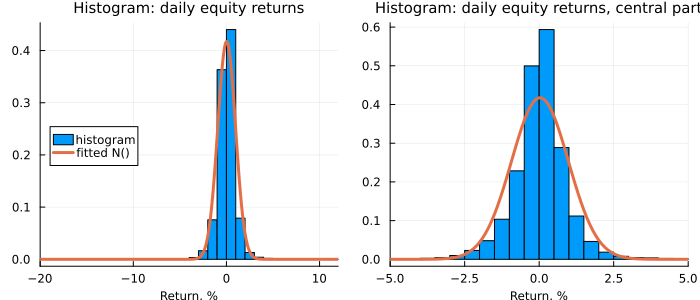

In [5]:
xGrid = -20:0.1:12
pdfX  = pdf.(Normal(μ,σ),xGrid)        #"Distributions.jl" wants σ, not σ^2

p1 = histogram( x,bins = -20:1:12,
                normalized = true,     #normalized to have area=1
                label = "histogram",
                legend = :left,
                xlim = (-20,12),
                title = "Histogram: daily equity returns",
                titlefontsize = 10,
                xlabel = "Return, %",
                guidefontsize = 8 )
plot!(xGrid,pdfX,linewidth=3,label="fitted N()")

p2 = histogram( x,bins = -5:0.5:5,
                normalized = true,
                legend = false,
                xlim = (-5,5),
                title = "Histogram: daily equity returns, central part",
                titlefontsize = 10,
                xlabel = "Return, %",
                guidefontsize = 8 )
plot!(xGrid,pdfX,linewidth=3,legend=false)

pAll = plot(p1,p2,layout=(1,2),size=(700,300))                  #set up subplots
display(pAll)

# Skewness, Kurtosis and the Bera-Jarque Test

### A Remark on the Code

- To calculate the 0.9 quantile (90th percentile) of a $\chi_2^2$-distribution, use `quantile(Chisq(2),0.9)`.

In [6]:
xStd     = (x .- μ)./σ               #first normalize to a zero mean, unit std variable
skewness = mean(xStd.^3)
kurtosis = mean(xStd.^4)

BJ = (T/6)*skewness.^2 + (T/24)*(kurtosis.-3).^2        #Bera-Jarque, Chisq(2)

critval_BJ   = quantile(Chisq(2),0.9)                   #critical values
critval_skew = quantile(Normal(0,sqrt(6/T)),0.9)
critval_kurt = quantile(Normal(0,sqrt(24/T)),0.9)

printblue("More descriptive stats:\n")
xx = hcat([skewness;kurtosis-3;BJ],[critval_skew;critval_kurt;critval_BJ])
printmat(xx,colNames=["Estimate","10% crit val"],rowNames=["skewness","excess kurtosis","Bera-Jarque"],width=15)

More descriptive stats:

                      Estimate   10% crit val
skewness                -0.519          0.025
excess kurtosis         16.166          0.051
Bera-Jarque         167896.608          4.605



# Q-Q Plot

The Q-Q plot shows the empirical quantiles against the theoretical quantiles (possibly from an estimated distribution). If the theoretical distribution is a good fit to the data, then the results should cluster closely around a 45 degree line.

### A Remark on the Code

There appears to be some inconsistence in how `Distributions.jl` calculate (a vector of) quantiles from data and from a distribution. If `pval1` is a vector of probabilities, then
- `quantile(x,pval1)` calculates a vector of empirical quantiles (notice: no dot). (You could also use and `quantile.(Ref(x),pval1)`.)

- `quantile.(Normal(μ,σ),pval1)` calculates a vector of quantiles of a `Normal(μ,σ)` distribution.

In [7]:
pval1 = 0.01:0.01:0.99                          #quantiles 0.01 to 0.99, to QQ plot
pval2 = [0.001:0.001:0.009;0.991:0.001:0.999]   #extreme quantiles

qEmp1 = quantile(x,pval1)                       #empirical quantiles; no dot
qEmp2 = quantile(x,pval2) 
qN1   = quantile.(Normal(μ,σ),pval1)            #quantiles of N()
qN2   = quantile.(Normal(μ,σ),pval2);           #quantiles of N()

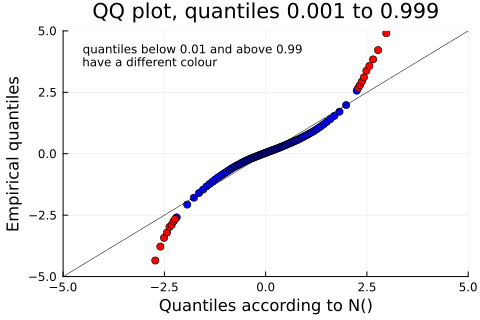

In [8]:
txt = text("quantiles below 0.01 and above 0.99\nhave a different colour",8,:left)

p1 = scatter( qN1,qEmp1,color=:blue,legend=false,
              xlim = (-5,5),
              ylim = (-5,5),
              title = "QQ plot, quantiles 0.001 to 0.999",
              xlabel = "Quantiles according to N()",
              ylabel = "Empirical quantiles",
              annotation = (-4.5,4,txt) )
scatter!(qN2,qEmp2,color=:red,legend=false)
plot!([-5,5],[-5,5],color=:black,linewidth=0.5)
display(p1)

# Empirical Distribution Function and the Kolmogorov-Smirnov Test

The empirical distribution function (edf) shows the empirical quantiles. The Kolmogorov-Smirnov (K-S) method is designed to test whether the edf differs from a theoretical (possibly estimated) cdf.

An edf does essentially the following: rank all elements in `x` and divide the ranks by `T` to get relative ranks (0 to 1).

The K-S test finds the largest difference between the edf and the theoretical cdf, $D$. The 5% critical value of $\sqrt{T}D$ is 1.36. 

### A Remark on the Code

- Let `x` be a vector of data. Then, `edfx = ecdf(x)` gives the empirical distribution function which can be used later on. In particular we can evaluate this function at some other points as in `edfx(z)`, where the result is the relative rank of the x[i]<=z closest to z. This is like flat interpolation.

In [9]:
edfx = ecdf(x)                   #construct the empirical distribution function

edfEmp = edfx(xGrid)                   #evaluate the empirical distribution function at xGrid
cdfN   = cdf.(Normal(μ,σ),xGrid);       #cdf of Normal(μ,σ), for comparison

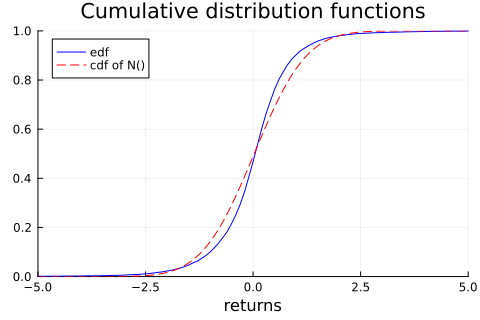

In [10]:
p1 = plot( xGrid,[edfEmp cdfN],
           label = ["edf" "cdf of N()"],
           linecolor = [:blue :red],
           linestyle = [:solid :dash],
           title = "Cumulative distribution functions",
           xlabel = "returns",
           xlim = (-5,5),
           ylim = (0,1) )
display(p1)

In [11]:
"""
    KolSmirPs(x1,TheoryCdf::Function)

Calculate the Kolmogorov-Smirnov test

# Output
- `KSstat::Float64`:     KS test statistic
- `xD::Number`:          x value with the largest diff beteen empirical and theoretical cdf

"""
function KolSmirPs(x1,TheoryCdf::Function)
    T            = length(x1)
    x1Sorted     = sort(x1)
    TheoryCdf_x  = TheoryCdf.(x1Sorted)
    edfH         = 1/T:1/T:1                        #empirical cdf for x1Sorted
    edfL         = 0:1/T:(1-1/T)
    D_candidates = abs.([edfH;edfL] - repeat(TheoryCdf_x,2))
    (D,vD)       = findmax(D_candidates)
    KSstat       = sqrt(T)*D
    xD           = repeat(x1Sorted,2)[vD]
    return KSstat, xD
end

KolSmirPs

In [12]:
(KSstat,xD) = KolSmirPs(x,z->cdf(Normal(μ,σ),z))

printblue("Kolmogorov-Smirnov test:\n")
printmat([KSstat,1.36,xD],rowNames=["sqrt(T)*D","5% critval","at which x"])

Kolmogorov-Smirnov test:

sqrt(T)*D      9.941
5% critval     1.360
at which x    -0.400

